In [1]:
import src.bloch_hamiltonian as blc
import src.disclination as disc

import numpy as np
from numpy import pi

import scipy as sp
import cupy as cp

from tqdm import tqdm

import matplotlib.pyplot as plt

# Define Pauli and Gamma matrices for convenience
sigma_0 = np.array([[1, 0], [0, 1]], dtype=complex)
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)

gamma_1 = np.kron(sigma_x, sigma_z)
gamma_2 = np.kron(-sigma_y, sigma_0)
gamma_3 = np.kron(sigma_z, sigma_0)
gamma_4 = np.kron(sigma_x, sigma_x)
gamma_5 = np.kron(sigma_x, sigma_y)

norb = 4

ModuleNotFoundError: No module named 'joblib'

In [204]:
# Real space in z Hamiltonian with a CDW potential added in
def z_ham(kx, ky, nz, k_cdw, delta, phi, params, **kwargs):
    h0, hz = blc.z_bloch_hamiltonian((kx, ky), *params)
    
    norb = h0.shape[0]

    hop_z = np.diag(np.ones(nz - 1), -1)

    ham = np.kron(np.identity(nz), h0)

    ham += np.kron(hop_z, hz)
    ham += np.kron(hop_z, hz).conj().T

    if 'pbc' in kwargs:
        if kwargs['pbc']:
            ham[0:norb, -norb:] += hz
            ham[-norb:, 0:norb] += hz.conj().T

    for ii in range(nz):
        ham[norb * ii:norb * (ii + 1), norb * ii:norb * (ii + 1)] += 2 * delta * np.cos(k_cdw * ii + phi) * gamma_5

    return ham

def k_cdw_to_m0_over_bz(k_cdw: float):
    return 1 - np.cos(k_cdw / 2)

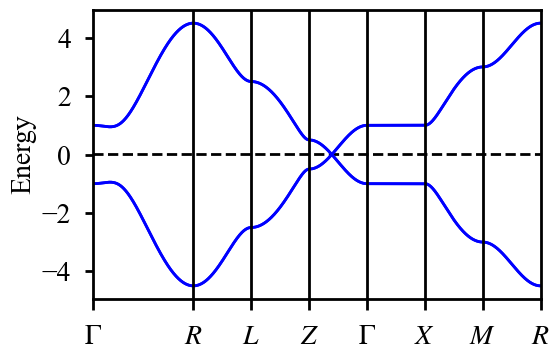

In [212]:
# Choose parameters and plot the band structure

nk = 50
nz = 100

k_cdw = 2 * pi / 3
delta = 2.0
phi = pi

k_ax = np.linspace(0, pi, nk + 1)[:-1]

m0 = 1.0
bz = m0 / k_cdw_to_m0_over_bz(k_cdw)

bxy = 1.0
g1 = 0.0
g2 = 0.0

params = (m0, bxy, bz, g1, g2)

c4_masses = (0.0, 0.0)

blc.plot_band_structure(0.01, *params, c4_masses=c4_masses, save=False)

In [213]:
# Use a numerical optimizer to find the minimum direct gap in the BZ
pbc = True

def gap_func(x, *args):
    kx, ky = x

    ham = cp.asarray(z_ham(kx, ky, nz, k_cdw, delta, phi, params, pbc=pbc))

    u = cp.asnumpy(cp.linalg.eigvalsh(ham))

    return u[norb // 2 * nz] - u[norb // 2 * nz - 1]

res = sp.optimize.minimize(gap_func, (pi / 2, pi / 2), method='Powell', bounds=((0, pi), (0, pi)))

print(f'Min gap location: (kx, ky) = ({res.x[0]:.4f}, {res.x[1]:.4f})')
print(f'Min gap value: {res.fun:.3g} eV')

Min gap location: (kx, ky) = (0.0000, 0.0000)
Min gap value: 0.471 eV


In [209]:
# Calculate the spectrum on a dense grid in one quadrant of the BZ
u = np.zeros((norb * nz, nk, nk))

for ii in tqdm(range(nk)):
    for jj in range(nk):
        ham = cp.asarray(z_ham(k_ax[ii], k_ax[jj], nz, k_cdw, delta, phi, params))
        u[:, ii, jj] = cp.asnumpy(cp.linalg.eigvalsh(ham))

100%|██████████| 50/50 [00:56<00:00,  1.13s/it]


Min gap value: 0.341 eV


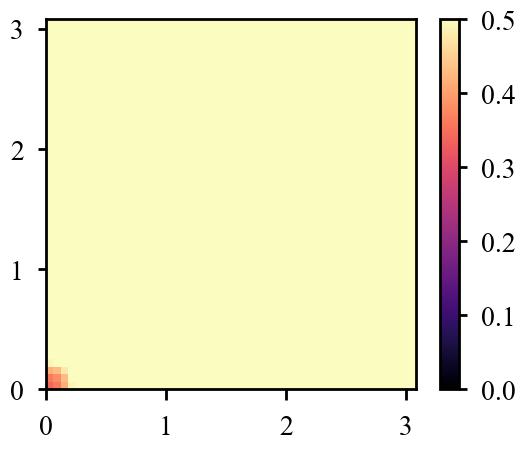

In [211]:
# Plot the gap over a quadrant of the BZ

data = u[norb // 2 * nz] - u[norb // 2 * nz - 1]

print(f'Min gap value: {np.min(data):.3g} eV')

plt.imshow(data.T, origin='lower', cmap='magma', vmin=0.0, vmax=0.5, extent=((0, k_ax[-1], 0, k_ax[-1])))
plt.colorbar()
plt.show()